## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

To understand the results of an A/B test run by an e-commerce website, I will work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Set the seed
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`.

a. Show the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# Subset of converted users
converted = df[df.converted==1]

converted.user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
control_new = (df.group=='control') & (df.landing_page=='new_page')
treatment_old = (df.group=='treatment') & (df.landing_page=='old_page')

len(df[control_new|treatment_old])

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**.
a. Create a new dataset and store it in **df2**.

In [8]:
# Drop rows where (treatment & new_page) or (control & old_page) are not lined up
idx = df[control_new|treatment_old].index
df2 = df.drop(idx, axis=0)
df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2**.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates('user_id', inplace=True)
df2.shape[0]

290584

`4.` Use **df2**.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control = df2[df2.group == 'control']
ctr_converted = control[control.converted == 1]

ctr_conv_rate = len(ctr_converted)/len(control)
ctr_conv_rate

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment = df2[df2.group == 'treatment']
trt_converted = treatment[treatment.converted == 1]

trt_conv_rate = len(trt_converted)/len(treatment)
trt_conv_rate

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
new_pg = df2[df2.landing_page == 'new_page']

len(new_pg)/len(df2)

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?

The probability of an individual converting regardless of the page they receive is 11.96%. 
By comparing the probability they converted, given that an individual was in the control group (12.04%) vs in the treatment group (11.88%), the difference is too small: 0.16%.

Similarly, the probability that an individual received either page is pretty even: 50.01% for the new one  vs 49.99% for the old one.

Based on the previous results, there is not evidence that suggest that one page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_0: P_{new} \leq P_{old} \implies P_{new} - P_{old} \leq 0$

$H_1: P_{new} > P_{old} \implies P_{new} - P_{old} > 0$

$ \alpha = 0.05 $

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

$H_0: P_{old} = P_{new} $

$H_1: P_{old} \neq P_{new}  $


In [18]:
p_old = p_new = df2.converted.mean()

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br>

In [20]:
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
# Number of individuals that received the new page
n_new = len(new_pg)
n_new

145310

d. What is $n_{old}$?

In [22]:
# Number of individuals that received the old page
n_old = len(df2) - n_new
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice(2, n_new, [p_new, 1-p_new])
new_page_converted

array([1, 1, 1, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice(2, n_old, [p_old, 1-p_old])
old_page_converted

array([0, 0, 0, ..., 1, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0033448260651262052

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
# Simulate difference in conversion rates using binomial distribution
new_pg_conversion = np.random.binomial(n_new, p_new, 10000) / n_new  # proportion of nulls on new_page
old_pg_conversion = np.random.binomial(n_old, p_old, 10000) / n_old  # proportion of nulls on old_page

p_diffs = new_pg_conversion - old_pg_conversion

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

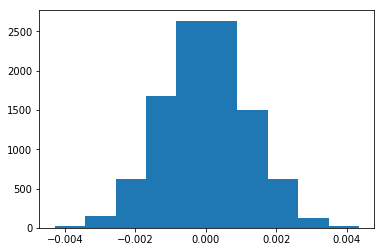

In [27]:
plt.hist(p_diffs);

It looks like a Normal Distribution per the Central Limit Theorem

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# Calculate actual difference of conversion rates observed in data
obs_diff = trt_conv_rate - ctr_conv_rate
obs_diff

-0.0015782389853555567

In [29]:
# Calculate the p-value
(np.array(p_diffs) > obs_diff).mean()

0.90580000000000005

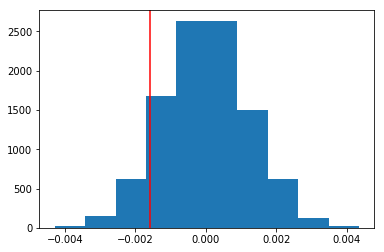

In [30]:
# Plot sampling distribution and observed difference
plt.hist(p_diffs);
plt.axvline(obs_diff, color = 'red');

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The proportion calculated in part j. is the **p-value**. This is the probability to observe the statistic coming or not from the null sampling distribution given the null hypothesis is true; it determines the statistical significance of the observed statistic.

This p-value means there is **90.58%** conditional probability that the observed statistic (difference in conversion rates proportions) comes from the null sampling distribution rather than due to chance, and as it is greater than the level of significance (alpha 5%), leads to the decision of failing to reject the null hypothesis, which sets the old page is better than the new page.

Statistically the old page has higher probability to lead to more conversions than the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = len(ctr_converted) # number of conversions from control
convert_new = len(trt_converted) # # number of conversions from treatment
n_old = len(control) # same lenght as aligned with old_page
n_new = len(treatment) # same lenght as aligned with new_page

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
# Calculate z-score and p-value
# number of successes [convert_old, convert_new] & number of trials [n_old, n_new]

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],\
                                             alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [33]:
from scipy.stats import norm

alpha = 0.05

print(norm.cdf(z_score)) # How significant the z-score is

print(norm.ppf(1-(alpha/2))) # Critical value at 95% confidence

0.905058312759
1.95996398454


Since the z-score of 1.31 does not exceed the critical value of 1.96 at 95% confidence, and the associated p-value of 90.51% is larger than the pre-set alpha of 5%, we fail to reject the null hypothesis that sets the conversion rate from the new page is lower than from the old page.

By comparing the above results with the ones on parts j. and k., the findings (even the p-values) are very similar. Therefore, both tests, the buil-in (z-test) and the sampling simulation under the null, lead to believe the old page has a higher conversion rate than the new page.

Statistically, per the above numbers, the company should keep the old page rather than implementing the new one.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
import statsmodels.api as sm

# Create dummy_variable column for which page each user received
df2['ab_page'] = pd.get_dummies(df2.group).treatment

# Create 'intercept' column
df2['intercept'] = 1

df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
# Create an instance of the Logistic Regression (control group as baseline)
log_model = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        17:34:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with **ab_page** is 0.19, and differs from the p-value (0.905) found in the **Part II** per the different hypothesis assumptions:

In the regression model, the null hypothesis sets there is no difference (= relation) in conversion rates between the control and treatment groups, as opposed to the alternative, which sets there is difference ($\neq$ relation).
While in the Part II, the null assumes the old page is better unless the new page proves the contrary, which in other words is equivalent to say the treatment group has a lower or equal conversion rate than the control group (implies $\leq$ relation), vs the alternative that sets it has a higher conversion rate (implies $\gt$ relation).

In the null and alternative hypothesis, the parameter (difference in conversion rate) is equal (=) or not ($\neq$) to zero in the regression model as corresponding, while in the Part II the parameter is compared ($\leq$ or $\gt$) to zero.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

A good idea to consider other factors to add into the regression model is in order to find a model that predict better the response variable or to identify which variables are useful predictors or not.

For example, the variable timestamp could be considered as a predictor factor in conversion rates if checked:
- per the average daily time users spend on a page, or
- per the time of the day (morning, afternoon, evening) or day of the week (weekday, weekend) users browse on a page...

By adding the variable timestamp, might help forecasting conversion for each group; however if it does not account for correlated errors, the correlation might be to our advantage to better predict the future. The predictions can be improved by using information from the past data points.

Other disadvantages:
By adding high terms into the model, it can help fitting more complex relationships in the data but adds complexity in the interpretation of the coefficients.

Also by adding other factors, the relationship between them has to be evaluated in order to avoid Multicollinearity; the idea is to include variables that are correlated to the response rather than correlated to other predictor variables; since it can lead to coefficients being flipped from the expected direction from simple linear regression.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.

Does it appear that country had an impact on conversion?

In [37]:
# Read dataset 'countries.csv'
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# Merge with Countries dataset into a new dataframe df3
df3 = df2.merge(df_countries, on='user_id')

In [39]:
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [40]:
# Create dummy variables for country (CA as baseline)
df3[['UK', 'US']] = pd.get_dummies(df3.country)[['UK', 'US']]
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,1


In [41]:
# Create an instance of the Logistic Regression (control group and country CA as baseline)
log_model2 = sm.Logit(df3.converted, df3[['intercept', 'ab_page', 'UK', 'US']])
results2 = log_model2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [42]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 06 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        17:34:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [43]:
# Calculate exponential of the coeffiecients
np.exp(results2.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [44]:
# Calculate the reciprocal for the page coefficient (since 0.985168 is < 1)
1/np.exp(results2.params[1])

1.0150555970226289

- All variables are statistically significant
- Conversion is 1.05 times more likely for users living in UK than in Canada holding all else constant.
- Conversion is 1.04 times more likely for users living in US than in Canada holding all else constant.
- For every less user is given a new page, conversion is 1.02 times more likely (regardless the country the user lives in), holding all other variables constant.

It does not seem the country has impact on conversion

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
# Interaction columns between page and country
df3['ab_page_UK'] = df3.UK*df3['ab_page']
df3['ab_page_US'] = df3.US*df3['ab_page']

df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,ab_page_UK,ab_page_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,1,0,0


In [46]:
# Create an instance of the Logistic Regression (control group and country CA as baseline)
# And add interaction columns between page and countries: UK & US
log_model3 = sm.Logit(df3.converted, df3[['intercept', 'ab_page', 'UK', 'US', 'ab_page_UK', 'ab_page_US']])
results3 = log_model3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [47]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 06 Nov 2018   Pseudo R-squ.:               3.482e-05
Time:                        17:34:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
ab_page_US     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [48]:
# Calculate exponential of the coeffiecients
np.exp(results3.params)

intercept     0.134794
ab_page       0.934776
UK            1.011854
US            1.017682
ab_page_UK    1.081428
ab_page_US    1.048001
dtype: float64

In [49]:
# Calculate the reciprocal for the page coefficient (since 0.934776 < 1)
1/np.exp(results3.params[1])

1.0697747746099582

- For every less user is given a new page, conversion is 1.07 times more likely than when given an old page, holding all other variables constant
- For every user that lives in UK, conversion is 1.01 times more likely than living in CA, holding all other variables constant
- For every user that lives in US, conversion is 1.02 times more likely than living in CA, holding all other variables constant
- For every user that lives in UK and is given a new page, conversion is 1.08 times more likely than living in CA and given an old page, holding else constant
- For every user that lives in US and is given a new page, conversion is 1.05 times more likely than living in CA and given an old page, holding else constant
- Per the above and the p-values of the coefficients, it does not seem that interaction between page and country affects significantly  on conversion

<a id='conclusion'></a>
### Conclusion

Per the probabilities calculated in Part I, the results do not show enough evidence that suggest that one page leads to more conversions. The chance individuals convert from groups control and treatment are pretty even.

By simulating the difference in conversion rates under the null, setting the null hypothesis as the old page is better than the new page, and the alternative as the opposite (at a type I error rate of 5%), the calculated p-value (~90.58%) lead to the decision of failing to reject the null.
Same decision was achieved through the z-test, with a z-score of 1.31 (< critical value of 1.96 at 95% confidence) associated to a p-value of 90.51% (very close to the got one in the simulation).
Per both tests, statistically the old version has higher probability to lead to more conversions than the new one.

By performing the (logistic) regression, the null hypothesis is set as there is no difference in conversion for both groups, control and treatment; the alternative sets there is difference. The associated p-values to the coefficients are small (the  variables ab_page, UK & US are statistically significant), and the multiplicative change in conversion is barely more than 1 time, suggesting the country has no impact on the conversion rate difference (failing to reject the null).
By adding the relation between the page and the country, the model does not show to be a better fit on predicting the conversion response.

Per the results of all these tests, statistically, the company should keep the old page rather than implementing the new version.
However, as the chance of conversion is around 12% (even regardless the group) and the difference in conversion for both is pretty small (0.16%), in practice, it might be better to invest improving on the new one in order to rise the conversion rate.

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0